## Model Exploration for the incNET project

In this notebook, the main objective is to explore multiple ML solutions to find one of the most optimum algorithm for our project.

To accelerate our model search, all galaxy images have been downsize to the resolution of 64x64 pixels.

In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from optparse import OptionParser
from PIL import Image#, ImageTk
from subprocess import Popen, PIPE
import matplotlib.patches as patches
import scipy.ndimage

import warnings
warnings.filterwarnings('ignore')

Here, all images and their labels are loaded. Everything have been already processed into a numpy zip data structure.

In [2]:
data = np.load('../data_64x64.npz')
images = data['images']
classs = data['labels'] 
data.close() 

## Images
Images are in RGB format. So, each images has three channels. In total 60,468 images have been stored in the imprted numpy array.

In [9]:
N = images.shape[0]  # the number of images in our dataset.
images.shape

(60468, 64, 64, 3)

## Labels

Labels are are in three different categories.

For rejected galaxies, label is `1`. These galaxies are either anomalous galaxies or are faint for the inclination measurements. If there are multiple galaxies in a frame that images has been also rejected.

If a galaxy is totally Face-on, or its inclination is less than 45 degrees, it is denoted by `1`.

If a galaxy is accepted and good for our measurements, the label is inclination value. Inclinations range between 45 and 90 degrees (with inclusive boundaries). 


- Reject: `0`
- Face-on: `1`
- inclination>45 : `inclination`

In [6]:
classs[:10]

array([[5807972, 5807972, 5807972, ..., 4011947, 4011947, 4011947],
       [      0,       0,       0, ...,       1,       1,       1]],
      dtype=int32)

## Converting colorful images to grayscale

To make it easier for the traditional ML algorithms to run our data with, we mix three color channel of images and make grayscale images. The following function facilitates the process.

In [11]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [15]:
GrayImages = np.zeros((N,64*64))

for i in range(N):
    GrayImages[i,:] = rgb2gray(images[i]).reshape(-1)
    
labels = classs[1]
pgcIDs = classs[0]
    
GrayImages.shape, labels.shape

((60468, 4096), (60468,))

Here, we visulaize one of the converted images next to its original colorful version. 

- First row displays [PGC38167](https://edd.ifa.hawaii.edu/cf4_photometry/get_sdss_cf4.php?pgc=38167) with the icnlination of `71` degrees.
- Second row shows [PGC5058880](https://edd.ifa.hawaii.edu/cf4_photometry/get_sdss_cf4.php?galname=PGC5058880) which has been rejected due to a proximity of a bright star in its projected image. 

pgcID: 38167 label: 71
pgcID: 5058880 label: 0


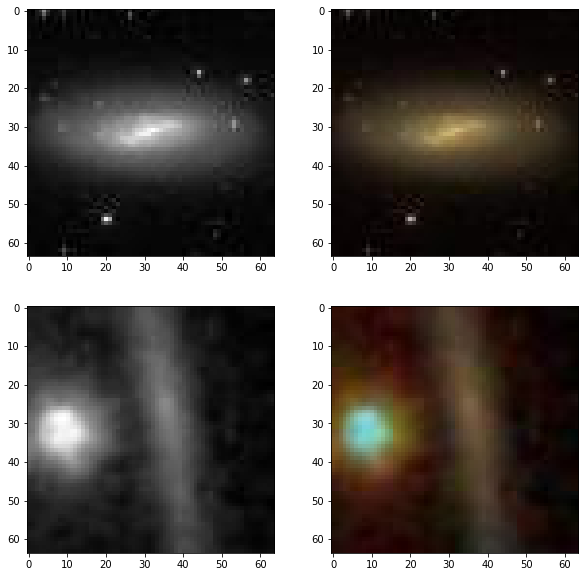

In [24]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(10,10))

i = 4
ax[0][0].imshow(GrayImages[i].reshape(64,64), cmap=plt.get_cmap('gray'))
ax[0][1].imshow(images[i])
print('pgcID: {} label: {}'.format(pgcIDs[i], labels[i]))

i = 4595
ax[1][0].imshow(GrayImages[i].reshape(64,64), cmap=plt.get_cmap('gray'))
ax[1][1].imshow(images[i])
print('pgcID: {} label: {}'.format(pgcIDs[i], labels[i]))

Here, we limit our calcualtions to those galaxies with accepted inclinations, i.e. those that are not rejected or face-on. 

In [25]:
## Getting rid of face-on (label = 1) and rejected (label = 0) galaxies
indx = (labels>1)

GrayImages = GrayImages[indx]
pgcIDs = pgcIDs[indx]
labels = labels[indx]

## Testing multiple ML models 

We use `scikit-learn` python package to examine different traditonal models and see evaluate their performances. 

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

from datetime import datetime
import time

To avoid confusions, grascale images have been flateneed and all of the them are stored in array `GrayImages`, which holds 44,220 images that are flatenned into 4,096 elements.  

In [31]:
X = GrayImages
y = labels

X.shape, y.shape

((44220, 4096), (44220,))

- Here, we decide to use classifiers for our purpose.
- The accuracy of each model has been evaluate in a 3-fold cross-validation process.

In [29]:
models = [KNeighborsClassifier(n_neighbors=1),
         KNeighborsClassifier(n_neighbors=3),
         LogisticRegression(solver='lbfgs', max_iter=1000), 
         DecisionTreeClassifier(max_depth=None), 
         RandomForestClassifier(max_depth=None, n_estimators=100, n_jobs=-1, random_state=42), 
         RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1, random_state=0),
         RandomForestClassifier(max_depth=None, n_estimators=1000, n_jobs=-1, random_state=0),
         XGBClassifier(max_depth=3, n_estimators=100, n_jobs=-1, random_state=42, eval_metric='mlogloss'),
        ]

for model in models:
    
    print('\n', model)
    score = cross_val_score(model, X, y, scoring='accuracy', cv=3).mean()
    print('Cross-Validation Accuracy:', score, '\n')
    
    print(datetime.now())

This for loop take a long time to be processed. Therefore, we managed to get a super computer to work on each model in parallel. Here is the outcome:

------------------------------------------------------
```
2021-07-29 22:53:41.629620

KNeighborsClassifier(n_neighbors=1)
Cross-Validation Accuracy: 0.11205336951605609 

2021-07-30 03:00:15.485862 
```
------------------------------------------------------
```
2021-07-29 22:53:41.994464

KNeighborsClassifier(n_neighbors=3)
Cross-Validation Accuracy: 0.10981456354590684 

2021-07-30 03:01:58.110096
```
------------------------------------------------------
```
2021-07-29 22:53:41.636286

LogisticRegression(max_iter=1000)
Cross-Validation Accuracy: 0.1125734961555857 

2021-07-29 23:56:27.854506
```
------------------------------------------------------
```
2021-07-29 22:53:41.322240

DecisionTreeClassifier()
Cross-Validation Accuracy: 0.10149253731343283 

2021-07-29 23:23:22.383522

```
------------------------------------------------------
```
2021-07-29 22:53:41.513511

RandomForestClassifier(n_jobs=-1, random_state=42)
Cross-Validation Accuracy: 0.14753505201266395 

2021-07-29 22:55:55.756751
```
------------------------------------------------------
```
2021-07-30 08:31:43.352541

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1,
                       random_state=0)
Cross-Validation Accuracy: 0.15113071008593396 
 
2021-07-30 08:41:18.737852
```
------------------------------------------------------
```
2021-07-30 08:31:43.492559

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)
Cross-Validation Accuracy: 0.157688828584351 
 

2021-07-30 08:45:37.041189
```
------------------------------------------------------
```
2021-07-29 22:53:41.466009

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='mlogloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
Cross-Validation Accuracy: 0.13683853459972864 
 
2021-07-30 02:01:58.916235
```
------------------------------------------------------

Comparing the accuracy metric for different models, Random Forest with 1000 estimators shows the best performance. However, the accuracy of the RF algorithm with smaller number of estimators is not significantly lower.

Here is the list of models sorted based on the estimated average accuracy:

- `RandomForestClassifier (n_estimator=1000)` Cross-Validation Accuracy: 0.158
- `RandomForestClassifier (n_estimator=1000, max_depth=10)` Cross-Validation Accuracy: 0.151
- `RandomForestClassifier (n_estimator=100)` Cross-Validation Accuracy: 0.148
- `XGBClassifier` Cross-Validation Accuracy: 0.137
- `LogisticRegression` Cross-Validation Accuracy: 0.113
- `KNeighborsClassifier(n_neighbors=1)` Cross-Validation Accuracy: 0.112
- `KNeighborsClassifier(n_neighbors=3)` Cross-Validation Accuracy: 0.110
- `DecisionTreeClassifier` Cross-Validation Accuracy: 0.101

### Is accuracy is a good metric in this process?

In classification problems, accuracy just measures how good an algorithm performs in finding the right classes. However, in this project inclinations are continuous variables. Therefore, the classification accuracy only reveals how much in overall an algorithm is better than the others.

To get better isights about the actual performacne of these model, below we plot the predictions versus the actual measured inclinations values and introduce another metric which is more suited for continues variables

## Auxiliriay function

### Shuffling an array 

This function is used to shuffle the elements of an array in a random fashipn. Changing the `seed` number, one can get different random shuffles. Using the same seed value implies the same results.

In [39]:
def esn_shuffle(array, seed=0):
        np.random.seed(seed)
        np.random.shuffle(array)
        return array

## Train/Test Split

This function is a customized function that takes the array of images, labels and the galaxies IDs and splits the data into training and testing sections.

Each images has been augmented by its mirrored and flipped (right/left, up/down, right-up/left-down) version. So, we require that the test set doesn't contain any of the different versions of training images.

In [40]:
def train_test_split(images, labels, pgcIDs, seed=0, n_test=2000):
    
    n = len(labels)

    indices = np.arange(n)
    indices = esn_shuffle(indices, seed=seed)


    images_ = images[indices]
    labels_ = labels[indices]
    pgcIDs_ = pgcIDs[indices]

    #################

    indices = np.arange(n_test)
    images_test  = images_[indices]
    labels_test  = labels_[indices]
    pgcIDs_test  = pgcIDs_[indices]

    ################# 

    indices = np.arange(n_test, n)
    images_train = images_[indices]
    labels_train = labels_[indices]
    pgcIDs_train = pgcIDs_[indices]


    ibx = np.logical_not(np.isin(pgcIDs_train, pgcIDs_test))
    images_train = images_train[ibx]
    labels_train = labels_train[ibx]
    pgcIDs_train = pgcIDs_train[ibx]

    #################
    # Taking only unique galxies in the test set
    # This is the brute-force approach.
    # I need to make this better in the future

    unique_IDs = []
    unique_inx = []

    for i, id in enumerate(pgcIDs_test):
        if not id in unique_IDs:
            unique_IDs.append(id)
            unique_inx.append(i)


    images_test  = images_test[unique_inx]
    labels_test  = labels_test[unique_inx]
    pgcIDs_test  = pgcIDs_test[unique_inx]
    
    trainDict = {'X':images_train, 'y':labels_train, 'id':pgcIDs_train}
    testDict  = {'X':images_test, 'y':labels_test, 'id':pgcIDs_test}
    
    return trainDict, testDict 

Here, we generate two different Train/Test sets with different seed numbers. This allows us to visualize different realizations of the same problem.

In [41]:
Train_seed0, Test_seed0 = train_test_split(GrayImages, labels, pgcIDs, seed=0)
Train_seed64, Test_seed64 = train_test_split(GrayImages, labels, pgcIDs, seed=64)

## A customize metric

For our purpose, we define a function to cross compare the predicted values against the manual measurements. This function returns Mean Absolute Error (MAE) and Root Mean Square Erro (RMSE).

In [47]:
from joblib import dump, load


def metrics(y1, y2):
    '''
    y1 and y2 are two series of the same size

    This function outputs the MAE, RMSE and R^2 
    of the cross evaluated series.

    '''
    y1 = y1.reshape(-1)
    y2 = y2.reshape(-1)
    RMSE = np.sqrt(np.mean((y1-y2)**2))
    MAE = np.mean(np.abs(y1-y2))

    print('MAE: %.3f'%MAE, ' RMSE: %.3f'%RMSE)
    
    return MAE, RMSE
########################################

def evalModel(Test_data, modelFile='', color='#1f77b4', ax=None, title='', model=None):
    
    if model is None:
        try:
            model = load(modelFile) 
        except:
            print("Please provide either a model or a file that contains the model.")
            return None
        
    
    inc_p = model.predict(Test_data['X'])  # predictions
    inc_m = Test_data['y']                 # measurements

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5)) 
        
    ax.plot(inc_m, inc_p+45, '.', color=color)
    ax.plot([48,95],[48,95], 'k:')
    ax.set_xlim(48,95)
    ax.set_ylim(48,95)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
    ax.set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)
    
    return inc_p+45, inc_m

## Generating different models

- We explore the efficiency of multiple models by training them with two different Training realizations.
- Each model is stored on disk in `.joblib` format.
- **Note:** We subtract 45 from label values. This way labels range from 0 to 45 (inclusive).

In [32]:
models = [("KNN1", KNeighborsClassifier(n_neighbors=1)),
         ("KNN3", KNeighborsClassifier(n_neighbors=3)),
         ("KNN5", KNeighborsClassifier(n_neighbors=5)),
         ("RF100", RandomForestClassifier(max_depth=None, n_estimators=100, n_jobs=-1, random_state=2)), 
         ]
          
for model in models:
    model.fit(Train_seed0['X'], Train_seed0['y']-45)
    dump(model, label+'_seed0.joblib') 
    
for model in models:
    model.fit(Train_seed64['X'], Train_seed64['y']-45)
    dump(model, label+'_seed64.joblib')    

## Random Forest (n_estimators=100)

In the following plots, the plot on the left is generated for `seed=0`, and the right panel represents the results for `seed=64`.


 Seed: 0 #############
MAE: 3.436  RMSE: 5.458

 Seed: 64 #############
MAE: 3.313  RMSE: 5.090
CPU times: user 2.03 s, sys: 1.34 s, total: 3.38 s
Wall time: 2.25 s


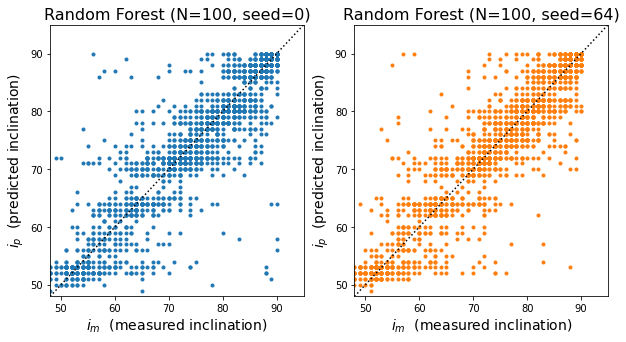

In [13]:
%%time 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

print('\n Seed: 0 #############')
inc_p, inc_m = evalModel(Test_seed0, 'RF100.joblib', 
                         title='Random Forest (N=100, seed=0)', ax=ax[0]) # N is the number of estimators
metrics(inc_p, inc_m)

inc_p, inc_m = evalModel(Test_seed64, 'RF100_seed64.joblib', 
                         title='Random Forest (N=100, seed=64)', ax=ax[1], color='#ff7f0e')

print('\n Seed: 64 #############')
metrics(inc_p, inc_m)

## k-nearest neighbors algorithm (K=1)

As seen below, the peformance of the KNN (K=1) is not better than that of Random Forest in the previous cell. 


 Seed: 0 #############
MAE: 4.259  RMSE: 6.476

 Seed: 64 #############
MAE: 4.167  RMSE: 6.216
CPU times: user 12min 45s, sys: 2.11 s, total: 12min 48s
Wall time: 13min 2s


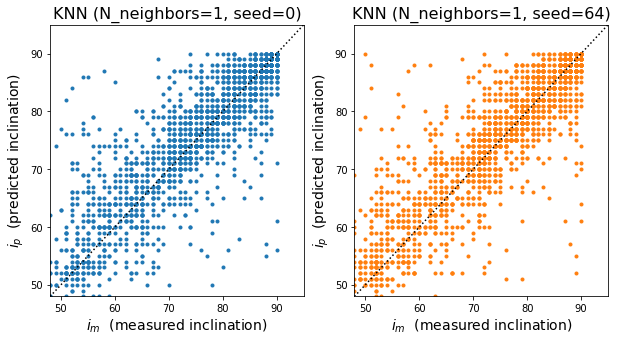

In [14]:
%%time 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

print('\n Seed: 0 #############')
inc_p, inc_m = evalModel(Test_seed0, 'KNN1.joblib', 
                         title='KNN (N_neighbors=1, seed=0)', ax=ax[0])
metrics(inc_p, inc_m)

inc_p, inc_m = evalModel(Test_seed64, 'KNN1_seed64.joblib', 
                         title='KNN (N_neighbors=1, seed=64)', ax=ax[1], color='#ff7f0e')

print('\n Seed: 64 #############')
metrics(inc_p, inc_m)

## k-nearest neighbors algorithm (K=3)

Evidently, increasing the number of neighbors doesn't significantly improve the predictions.


 Seed: 0 #############
MAE: 4.348  RMSE: 6.661

 Seed: 64 #############
MAE: 4.197  RMSE: 6.262
CPU times: user 13min, sys: 1.95 s, total: 13min 2s
Wall time: 13min 16s


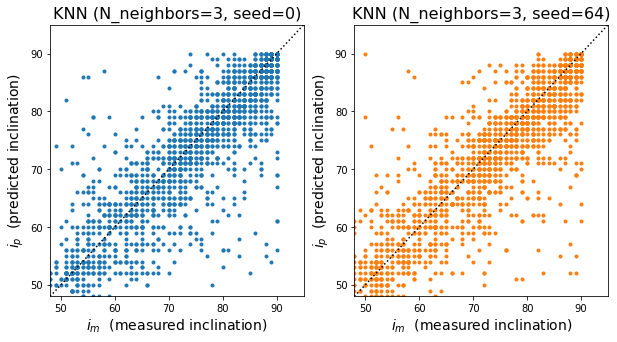

In [15]:
%%time 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

print('\n Seed: 0 #############')
inc_p, inc_m = evalModel(Test_seed0, 'KNN3.joblib', 
                         title='KNN (N_neighbors=3, seed=0)', ax=ax[0])
metrics(inc_p, inc_m)

inc_p, inc_m = evalModel(Test_seed64, 'KNN3_seed64.joblib', 
                         title='KNN (N_neighbors=3, seed=64)', ax=ax[1], color='#ff7f0e')

print('\n Seed: 64 #############')
metrics(inc_p, inc_m)

## k-nearest neighbors algorithm (K=5)

We get the similar performance to other KNN models when using K=5. So, we stop testing other KNNs with different k-values. 


 Seed: 0 #############
MAE: 4.427  RMSE: 7.016

 Seed: 64 #############
MAE: 4.263  RMSE: 6.413
CPU times: user 13min, sys: 3.52 s, total: 13min 3s
Wall time: 13min 31s


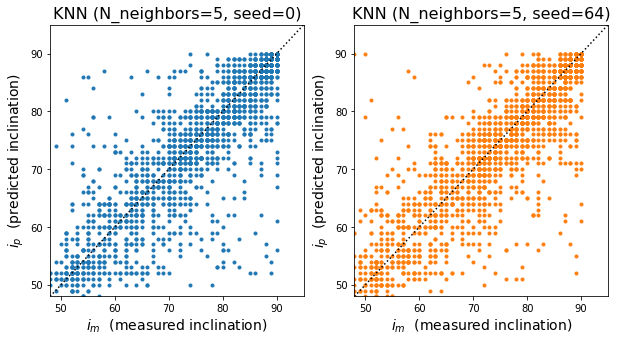

In [16]:
%%time 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

print('\n Seed: 0 #############')
inc_p, inc_m = evalModel(Test_seed0, 'KNN5.joblib', 
                         title='KNN (N_neighbors=5, seed=0)', ax=ax[0])
metrics(inc_p, inc_m)

inc_p, inc_m = evalModel(Test_seed64, 'KNN5_seed64.joblib', 
                         title='KNN (N_neighbors=5, seed=64)', ax=ax[1], color='#ff7f0e')

print('\n Seed: 64 #############')
metrics(inc_p, inc_m)

## XGBoost (n_estimatros:100, max_depth:3)

We generate the model first, and we save it on disk. This took ~7 hours on the machine that generated this notebook.

Unfortunately, my attempts to run this model on other faster machines and loading them here on t his notebook did not work, because of the version incompatibility of the installed `xgboost` packages.

In [14]:
%%time 
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=3, n_estimators=100, n_jobs=-1, random_state=0, eval_metric='mlogloss')
model.fit(Train_seed0['X'], Train_seed0['y']-45)
dump(model, 'test_XGB3.joblib')

CPU times: user 6h 53min 5s, sys: 3.69 s, total: 6h 53min 9s
Wall time: 6h 53min 1s


['test_XGB3.joblib']

### Loading the XGBoost model and plotting

MAE: 3.540  RMSE: 5.440


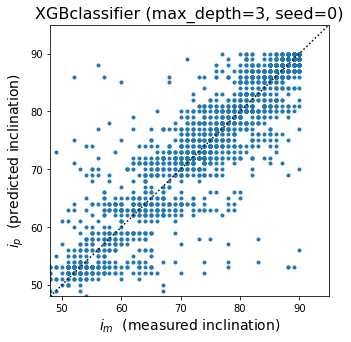

In [23]:
inc_p, inc_m = evalModel(Test_seed0, 'test_XGB3.joblib', 
                         title='XGBclassifier (max_depth=3, seed=0)')
metrics(inc_p, inc_m)

## XGBoost (n_estimatros:100, max_depth:5)

Apparently, increasing the depth level of XGBoost doesn't improve the performance.

In [16]:
%%time 

model5 = XGBClassifier(max_depth=5, n_estimators=100, n_jobs=-1, random_state=0, eval_metric='mlogloss')
model5.fit(Train_seed0['X'], Train_seed0['y']-45)
dump(model5, 'test_XGB5.joblib')

CPU times: user 11h 43min, sys: 3.69 s, total: 11h 43min 4s
Wall time: 11h 43min 27s


['test_XGB5.joblib']

MAE: 3.537  RMSE: 5.338


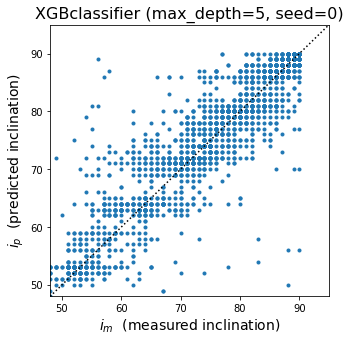

In [24]:
inc_p, inc_m = evalModel(Test_seed0, 'test_XGB5.joblib', 
                         title='XGBclassifier (max_depth=5, seed=0)')
metrics(inc_p, inc_m)

## Which model performs the best so far?

Looking at all of the evaluation results we have obtained, *Random Forest** shows better performance among the tested models.

One needs to note that in case of `LogisticRegression`, the algorithm did not converge after 1000 iterations. So, `LogisticRegression` in the current setup shows the worst results. 

# Neural Network

Here, we use `tensorflow` to build a fully connected neural network.
This model can be either fed with colorful or grayscale images. To be consistent, first we train the model using the grayscale images.

Prior to the analysis, we normalize image by dividing them by 255. This helps to improve the training flow of the NN model.

**Notes:**
- The shape of the neural network has been chosen in a trial and error effort
- We noticed that without a dropout layer, it's almost impassible to train this model. Without any drop-outs, all predictions are always mapped to the same value.
- Using a *Batch Normalization* layer right before the very last layer improves the performance. 

In [125]:
# TensorFlow and tf.keras
import tensorflow as tf


model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.20),    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(46),
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Training the NN

- **batch size:** *512*
- **shuffle:** *True*, means that at each epoch different batch combinations/permutations are utilized for training.
- We use the test sample as the validation sample just for the purpose of calculating the metrics, which is `accuracy` in our case.

In [126]:
n_epochs = 12
model.fit(Train_seed0['X']/255., Train_seed0['y']-45, 
          epochs=n_epochs, 
          batch_size=512, 
          shuffle=True,
          validation_data=(Test_seed0['X']/255., Test_seed0['y']-45)
         )

Epoch 1/12
72/72 [==============================] - 8s 106ms/step - loss: 7.0785 - accuracy: 0.0440 - val_loss: 8.6450 - val_accuracy: 0.0397
Epoch 2/12
72/72 [==============================] - 8s 105ms/step - loss: 5.0320 - accuracy: 0.0501 - val_loss: 4.4855 - val_accuracy: 0.0397
Epoch 3/12
72/72 [==============================] - 8s 106ms/step - loss: 4.1238 - accuracy: 0.0531 - val_loss: 6.1220 - val_accuracy: 0.0402
Epoch 4/12
72/72 [==============================] - 8s 105ms/step - loss: 3.8301 - accuracy: 0.0451 - val_loss: 3.5945 - val_accuracy: 0.0295
Epoch 5/12
72/72 [==============================] - 8s 109ms/step - loss: 3.5686 - accuracy: 0.0468 - val_loss: 3.5009 - val_accuracy: 0.0380
Epoch 6/12
72/72 [==============================] - 8s 107ms/step - loss: 3.4550 - accuracy: 0.0464 - val_loss: 3.4069 - val_accuracy: 0.0348
Epoch 7/12
72/72 [==============================] - 8s 113ms/step - loss: 3.5788 - accuracy: 0.0400 - val_loss: 4.3523 - val_accuracy: 0.0241
Epoch 

In [127]:
def plot_model_history(history, n_epochs=10):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

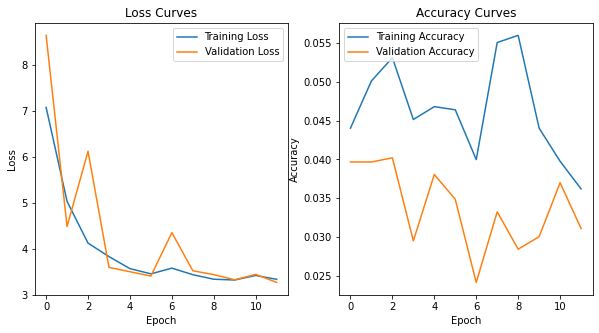

In [128]:
plot_model_history(model.history, n_epochs=n_epochs)

In [129]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(Test_seed0['X']/255.)

MAE: 8.432  RMSE: 10.723


(8.431939978563772, 10.722855756939808)

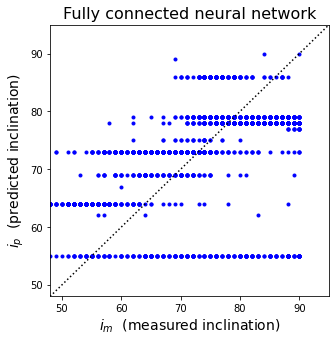

In [130]:
inc_p = np.argmax(predictions, axis=1)+45   # predictions
inc_m = Test_seed0['y']                     # measurements

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    
ax.plot(inc_m, inc_p, '.', color='b')
ax.plot([48,95],[48,95], 'k:')
ax.set_xlim(48,95)
ax.set_ylim(48,95)
ax.set_title('Fully connected neural network', fontsize=16)
ax.set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax.set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

metrics(inc_p, inc_m)

### Fully connected NN doesn't perform well.

As seen, among all models we evaluated in this notebook, a classic neural network shows the weakest results. 


This is expected, because of the huge number of variables that need to be trained and the morphology on the netwrok that doesn't preserve the rectangular shape of the image.

These isseus can be addressed by leveraging the power on *Convolutional Neural Neetworks*. Please follow [this notebook](https://github.com/ekourkchi/incNET-data/blob/master/incNET_modelExploration/CNN_inc_VGG6_classify.ipynb) for more details of the CNN model we created and trained.

## Convolutional Neural Network

### Results ....

For the sake of completing this notebook, we repeat the same process using the grayscale images, however once can expect better performance using all three different colors.

### 2D grayscalse images

First, we need to generate 2D grayscale image.

In [111]:
GrayImages2D = np.zeros((N, 64,64,1))

for i in range(N):
    GrayImages2D[i,:,:,:] = rgb2gray(images[i]).reshape(64,64,1)

In [112]:
labels = classs[1]
pgcIDs = classs[0]

indx = (labels>1)
GrayImages2D = GrayImages2D[indx]
pgcIDs = pgcIDs[indx]
labels = labels[indx]

GrayImages2D.shape

(44220, 64, 64, 1)

### Train/Test splitting

In [113]:
Train2D_seed0, Test2D_seed0 = train_test_split(GrayImages2D, labels, pgcIDs, seed=0)

In [114]:
Train2D_seed0['X'].shape, Train2D_seed0['y'].shape

((36756, 64, 64, 1), (36756,))

## Model definition using tensoflow

The number of layer and desing of the network has been chosen by try and error. It is obvious that this might not the best solution. 

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def vgg6(input_shape=(64, 64, 1), n_classes= 46):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 64x64 images with 1 channel -> (64, 64, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Dense(128, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.25))
    
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

## Compiling the model

We have chosen `accuracy` as the main metric to train the model.
However, as mentioned above the continuous nature of inclinations calls for a more reliable metric definition, i.e. somethings similar to `MAE` or `RMSE`.

In [116]:
vgg_model = vgg6()
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
n_epochs = 15
vgg_model.summary()
vgg_model_history = vgg_model.fit(Train2D_seed0['X']/255., Train2D_seed0['y']-45, 
                                  epochs=n_epochs, batch_size=512, verbose=2, 
                                  validation_split=0.2,
                                  shuffle=True)


Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 62, 62, 16)        160       
_________________________________________________________________
conv2 (Conv2D)               (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 30, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 26, 26, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 26, 26, 32)        128    

### Plotting the `loss` function and `accuracy` 
of network as its is trained

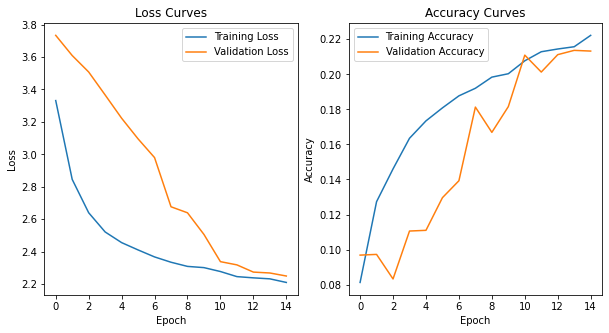

In [117]:
plot_model_history(vgg_model_history, n_epochs=15)

## Making predictions

- **Note**: Make sure that the test data have been normalized in a similar was as the training data.


In [123]:
predictions = vgg_model.predict(Test2D_seed0['X']/255.)

predictions.shape

(1866, 46)

- For each galaxy the output is an array of 46 numbers that hold the probability of the corresponding labels.

In [124]:
predictions[0]

array([1.3519542e-05, 2.8941236e-05, 3.0405077e-05, 5.8630212e-05,
       1.7296078e-04, 5.3933263e-04, 1.4609916e-03, 5.0426959e-03,
       7.5319293e-03, 3.1218449e-02, 2.5705280e-02, 7.1297273e-02,
       1.1999957e-01, 1.0809279e-01, 1.4634487e-01, 1.3522683e-01,
       7.6324910e-02, 9.8172851e-02, 9.4290219e-02, 4.1177940e-02,
       1.7269090e-02, 7.0979227e-03, 5.6897444e-03, 1.5287015e-03,
       2.8328381e-03, 1.2271899e-03, 8.5231481e-04, 2.0310252e-04,
       6.0551189e-05, 2.6308207e-05, 3.8564089e-05, 1.0791246e-04,
       2.1001022e-06, 5.4381567e-06, 1.8670521e-04, 6.8470722e-06,
       1.0765877e-05, 3.8011474e-06, 4.4984412e-05, 1.7331478e-05,
       4.1530425e-06, 8.4082549e-06, 1.4605707e-05, 1.7070266e-05,
       3.8529292e-06, 9.3520566e-06], dtype=float32)

For each galaxy, we use `argmax` to determine the index of the label with highest probability.

MAE: 2.458  RMSE: 4.100


(2.4581993569131835, 4.099708509231421)

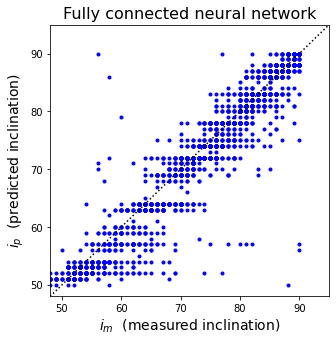

In [120]:
inc_p = np.argmax(predictions, axis=1)+45     # predictions
inc_m = Test2D_seed0['y']                     # measurements

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    
ax.plot(inc_m, inc_p, '.', color='b')
ax.plot([48,95],[48,95], 'k:')
ax.set_xlim(48,95)
ax.set_ylim(48,95)
ax.set_title('Fully connected neural network', fontsize=16)
ax.set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax.set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

metrics(inc_p, inc_m)

# Conclusion ...

In this study the convolutional neural network outperforms other algorithms. It also enables us to do the analysis using all three color channels.
TensorFlow facilitates the training process to be executed in parallel on GPU which is a great benefit. Also, with CNN it is easier to scale up the project and train networks for larger images with higher resolutions.

On the other hand, fully connected neural network do not perform well. Practically, they are not useful and certainty not better than a traditional Nearest Neighbor algorithm.

Random Forest (RF) is the next best algorithm if one ever wants to choose a method other than CNN. Although, the performance of an RF is not better than CNN, the training process is fast and predictions are performed very rapidly.

XGboost is also another good alternative in this project. However, the model takes a lot of time to train and in the end its performance is comparable to that of RF.

In our case, k-NN also performs reasonably, however they are lazy, meaning that they are very fast to train and slow in prediction. Basically, k-NN doesn't need much of a training process, because all the calculations are carried out at the time of prediction. Therefore, they are not best choices when it comes to deploy the prediction model for fast evaluation of inclination of a large galaxy catalog. 